# Confidence Intervals

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import warnings

warnings.simplefilter("ignore")

import os
import sys
import numpy as np

from itertools import product
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-colorblind")
PLT_COLOR = plt.rcParams["axes.prop_cycle"].by_key()["color"]
PLT_LINES = ["-", "--", ":", "-."]
PLT_CYCLER = cycler(color=PLT_COLOR * 2) + cycler(linestyle=PLT_LINES * 3)

import pandas as pd

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.plotting.register_matplotlib_converters()


import logging

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
import scipy
import seaborn as sns
from functools import partial
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(1)

# Parameters

In [4]:
ALPHA = 0.95

# Functions

In [5]:
def plot_result_toax(ax, alpha, preds, data):

    assert len(preds) == 3, "Predicitons require 3 entries"

    y_lower, y_pred, y_upper = preds
    X_train, y_train, X_test, y_test = data

    fill_color = PLT_COLOR[3]
    ax.plot(
        X_train,
        y_train,
        ".",
        color=PLT_COLOR[0],
        alpha=0.3,
        markersize=2,
        label="y_train",
    )
    ax.plot(
        X_train,
        y_train,
        ".",
        color=PLT_COLOR[0],
        alpha=0.3,
        markersize=2,
        label="y_test",
    )

    ax.fill(
        np.concatenate([X_test, X_test[::-1]]),
        np.concatenate([y_upper, y_lower[::-1]]),
        alpha=0.5,
        fc=fill_color,
        ec="none",
        label="{:.0%} prediction interval".format(alpha),
    )
    ax.plot(X_test, y_upper, "-", color=fill_color)
    ax.plot(X_test, y_lower, "-", color=fill_color)
    ax.plot(X_test, y_pred, "-k", label="Prediction")
    ax.legend(loc="upper left")
    return ax


def plot_result(alpha, preds, X_train, y_train, X_test, y_test):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    _ = plot_result_toax(ax, alpha, preds, data)
    return ax

# Generate Data

In [6]:
def f(u):
    return u * np.sin(u) + u * np.sin(2 * u) + u


def add_noise(y):
    dy = 1.5 + 5 * np.random.random(y.shape)
    y += np.random.normal(0, dy)
    return y


def generate_data(random_seed=1, xmin=-10, xmax=30, size=10000):
    """
    Generates data sample as seen in 'Prediction Intervals for Gradient Boosting Regression'
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
    """
    np.random.seed(random_seed)

    X_train = np.atleast_2d(np.random.uniform(xmin, xmax, size=size)).T
    X_train = X_train.astype(np.float32)

    X_test = np.atleast_2d(np.linspace(xmin, xmax, size)).T
    X_test = X_test.astype(np.float32)

    # Noisy training data:
    y_train = f(X_train).ravel()
    y_train = add_noise(y_train).astype(np.float32)

    # Noisy test data:
    y_test = f(X_test).ravel()
    y_test = add_noise(y_test).astype(np.float32)

    return X_train, y_train, X_test, y_test

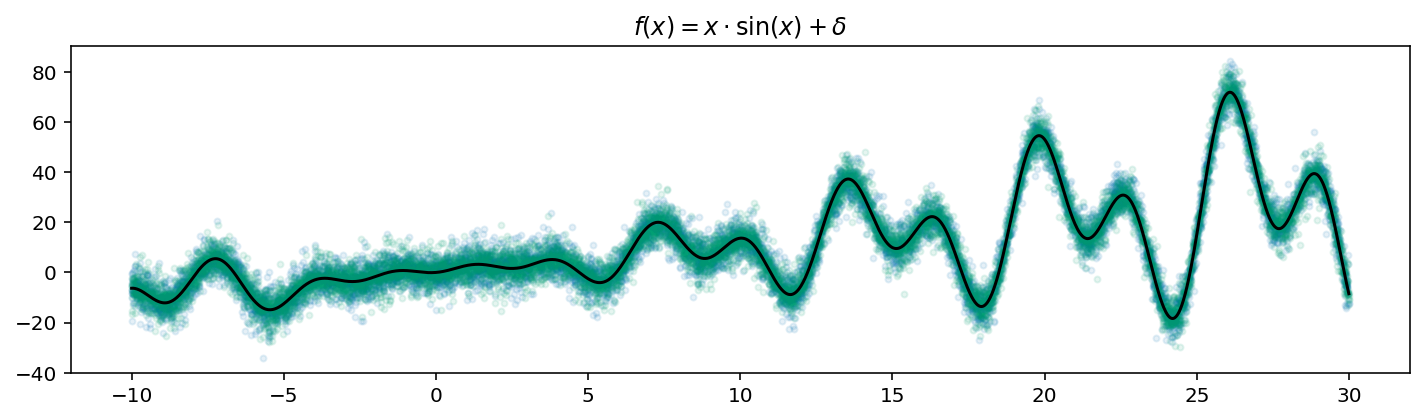

In [7]:
X_train, y_train, X_test, y_test = generate_data()
data = (X_train, y_train, X_test, y_test)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
_ = ax.plot(X_train, y_train, marker=".", alpha=0.1, linestyle="none")
_ = ax.plot(X_test, y_test, marker=".", alpha=0.1, linestyle="none")
_ = ax.plot(np.array(sorted(X_train)), f(np.array(sorted(X_train))), "k")

_ = ax.set_title("$f(x)=x\cdot\sin(x)+\delta$")

# Quantile Loss Example
Asymmetric penalization of errors, i.e. with the pinball loss function with $\varepsilon := y_\text{true} - y_\text{pred}$ <br>



$
\begin{align}
\label{eq:qLoss}
L_{q}(\varepsilon)=\begin{cases}
q\cdot\varepsilon & \text{if }\varepsilon\geq0\\
(1-q)\cdot\varepsilon & \text{if }\varepsilon<0
\end{cases}
\end{align}
$
<br>
<br>
$\rightarrow$ Median loss (i.e. the 50% quantile) is symmetric:

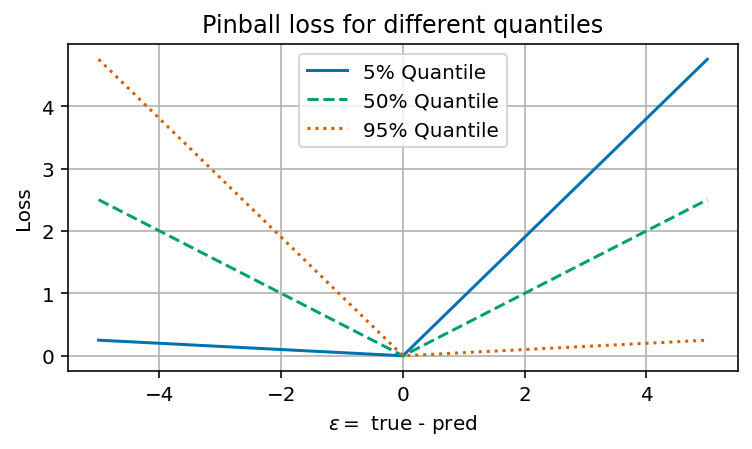

In [8]:
def quantile_loss(y_true, y_pred, quantile):
    residual = y_true - y_pred
    return np.maximum(quantile * residual, (quantile - 1) * residual)


xx = np.linspace(-5, 5, 101)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.set_prop_cycle(PLT_CYCLER)
for q in [1 - ALPHA, 0.5, ALPHA]:
    _ = ax.plot(xx, quantile_loss(0, xx, q), label="{:.0%} Quantile".format(q))
_ = ax.legend()
_ = ax.set_title("Pinball loss for different quantiles")
_ = ax.set_xlabel(r"$\varepsilon=\hspace{.03}$ true - pred")
_ = ax.set_ylabel("Loss")
_ = ax.grid()

# Quantile LogCosh Loss Example
* Using only pinball loss could worsen the model performance, though. <br>
* One might implement some fancier loss functions in order to get some asymptotic pinball behavior but with a different loss function for smaller deviations: Huber & LogCosh Loss!

d/dx log(cosh((a*x)) = a tanh(a x) <br>
d^2/dx^2 log(cosh((a*x)) = a^2 sech^2(a x)<br>

d/dx log(cosh((1-a)*x)) = -(-1 + a) tanh(x - a x)<br>
d^2/dx^2 log(cosh((1-a)*x)) = (1 - a)^2 sech^2(x - a x)<br>

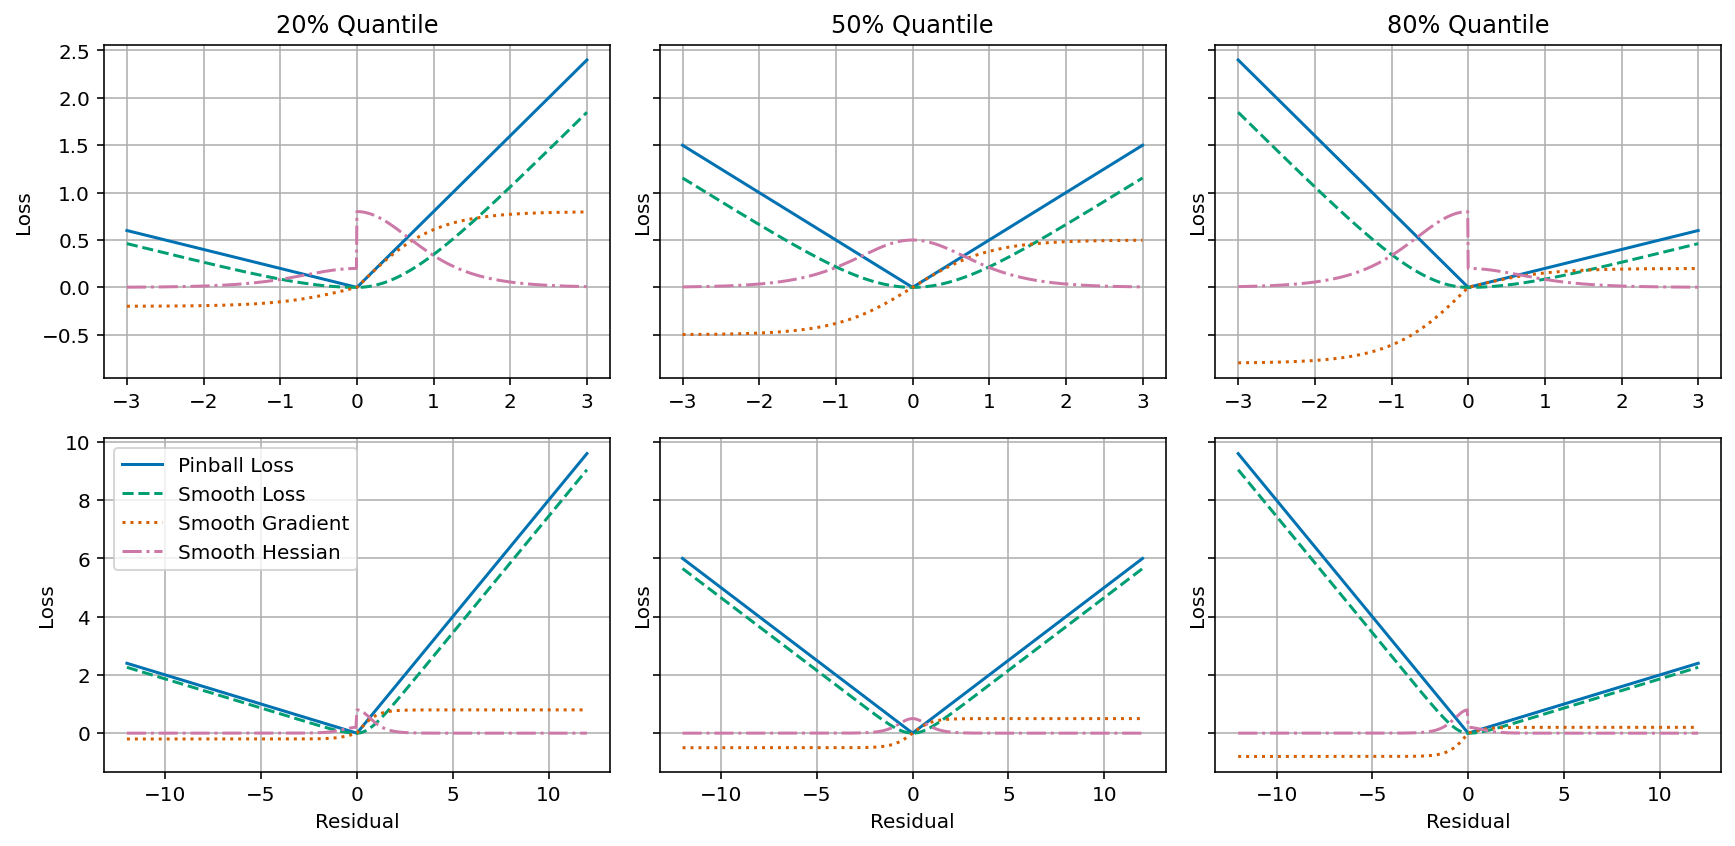

In [9]:
def quantile_loss(y_true, y_pred, q=0.5):
    """Quantile (pinball) loss."""
    err = y_pred - y_true
    return abs(np.where(err < 0, q * err, (1 - q) * err))


def quantile_loss_smooth(y_true, y_pred, q=0.5):
    """Smooth ln(cosh(x)) quantile loss."""
    err = y_pred - y_true
    return np.where(err < 0, q * np.log(np.cosh(err)), (1 - q) * np.log(np.cosh(err)))


def quantile_objective_smooth(y_true, y_pred, q=0.5):
    """
    Objective function returning gradient and Hessian 
    of the smooth quantile loss. With this, we avoid a 'zero-everywhere' Hessian.
    """
    err = y_pred - y_true
    grad = np.where(err < 0, q * np.tanh(err), (1 - q) * np.tanh(err))
    hess = np.where(err < 0, q * np.cosh(err) ** -2, (1 - q) * np.cosh(err) ** -2)
    return grad, hess


xl = 3
xx_list = [np.linspace(-xl, xl, 1001), np.linspace(-xl * 4, xl * 4, 501)]

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharey="row")
axs = axs.flat
q_list = [0.2, 0.5, 0.8]
for idx, (x, q) in enumerate(product(xx_list, q_list)):

    ax = axs[idx]
    ax.set_prop_cycle(PLT_CYCLER)

    _ = ax.plot(x, quantile_loss(0, x, q), label="Pinball Loss")
    _ = ax.plot(x, quantile_loss_smooth(0, x, q), label="Smooth Loss")
    _ = ax.plot(x, quantile_objective_smooth(0, x, q)[0], label="Smooth Gradient",)
    _ = ax.plot(x, quantile_objective_smooth(0, x, q)[1], label="Smooth Hessian",)
    _ = ax.grid()
    _ = ax.set_ylabel("Loss")

    if idx < 3:
        _ = ax.set_title("{:.0%} Quantile".format(q))
    if idx == 3:
        _ = ax.legend()
    if idx > 2:
        _ = ax.set_xlabel("Residual")

plt.tight_layout()

# Standard Quantile Regressions for GBDTs
* scikit-learn: Native implementation, but sub-standard performance of estimator.
* CatBoost: Native implementation.
* LightGBM: Native implementation.
* XGBoost: No native implementation, requires customized loss function as above.

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


sklearn_params = {
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.1,
    "min_samples_leaf": 9,
    "min_samples_split": 9,
}

cat_params = {"verbose": 0}

lgb_params = {"force_row_wise": True, "verbose": -1}

xgb_params = {
    "random_state": 0,
    "verbosity": 0,
}

In [11]:
skl_preds = list()
cat_preds = list()
lgb_preds = list()
xgb_preds = list()
for q in [1 - ALPHA, 0.5, ALPHA]:
    print("prediction of {:.0%} quantile".format(q))

    gbr = GradientBoostingRegressor(loss="quantile", alpha=q, **sklearn_params)
    skl_preds.append(gbr.fit(X_train, y_train).predict(X_test))

    gbr = CatBoostRegressor(loss_function=f"Quantile:alpha={q}", **cat_params)
    cat_preds.append(gbr.fit(X_train, y_train).predict(X_test))

    gbr = LGBMRegressor(objective="quantile", alpha=q, **lgb_params)
    lgb_preds.append(gbr.fit(X_train, y_train).predict(X_test))

    objective = partial(quantile_objective_smooth, q=q)
    gbr = XGBRegressor(objective=objective, **xgb_params)
    xgb_preds.append(gbr.fit(X_train, y_train).predict(X_test))

preds = {
    "sklearn": skl_preds,
    "CatBoost": cat_preds,
    "LightGBM": lgb_preds,
    "XGBoost": xgb_preds,
}

prediction of 5% quantile
prediction of 50% quantile
prediction of 95% quantile


In [12]:
for idx, (t, p) in enumerate(preds.items()):
    smaller = (p[2] < data[3]).mean()
    larger = (p[0] > data[3]).mean()
    s = "{:<9} {:4.1f}% ({:4.1f}%) test data larger (smaller) than interval.".format
    print(s(f"{t}:", larger * 100, smaller * 100))

sklearn:   5.7% ( 6.0%) test data larger (smaller) than interval.
CatBoost:  5.3% ( 5.8%) test data larger (smaller) than interval.
LightGBM:  5.1% ( 5.3%) test data larger (smaller) than interval.
XGBoost:   8.1% ( 8.3%) test data larger (smaller) than interval.


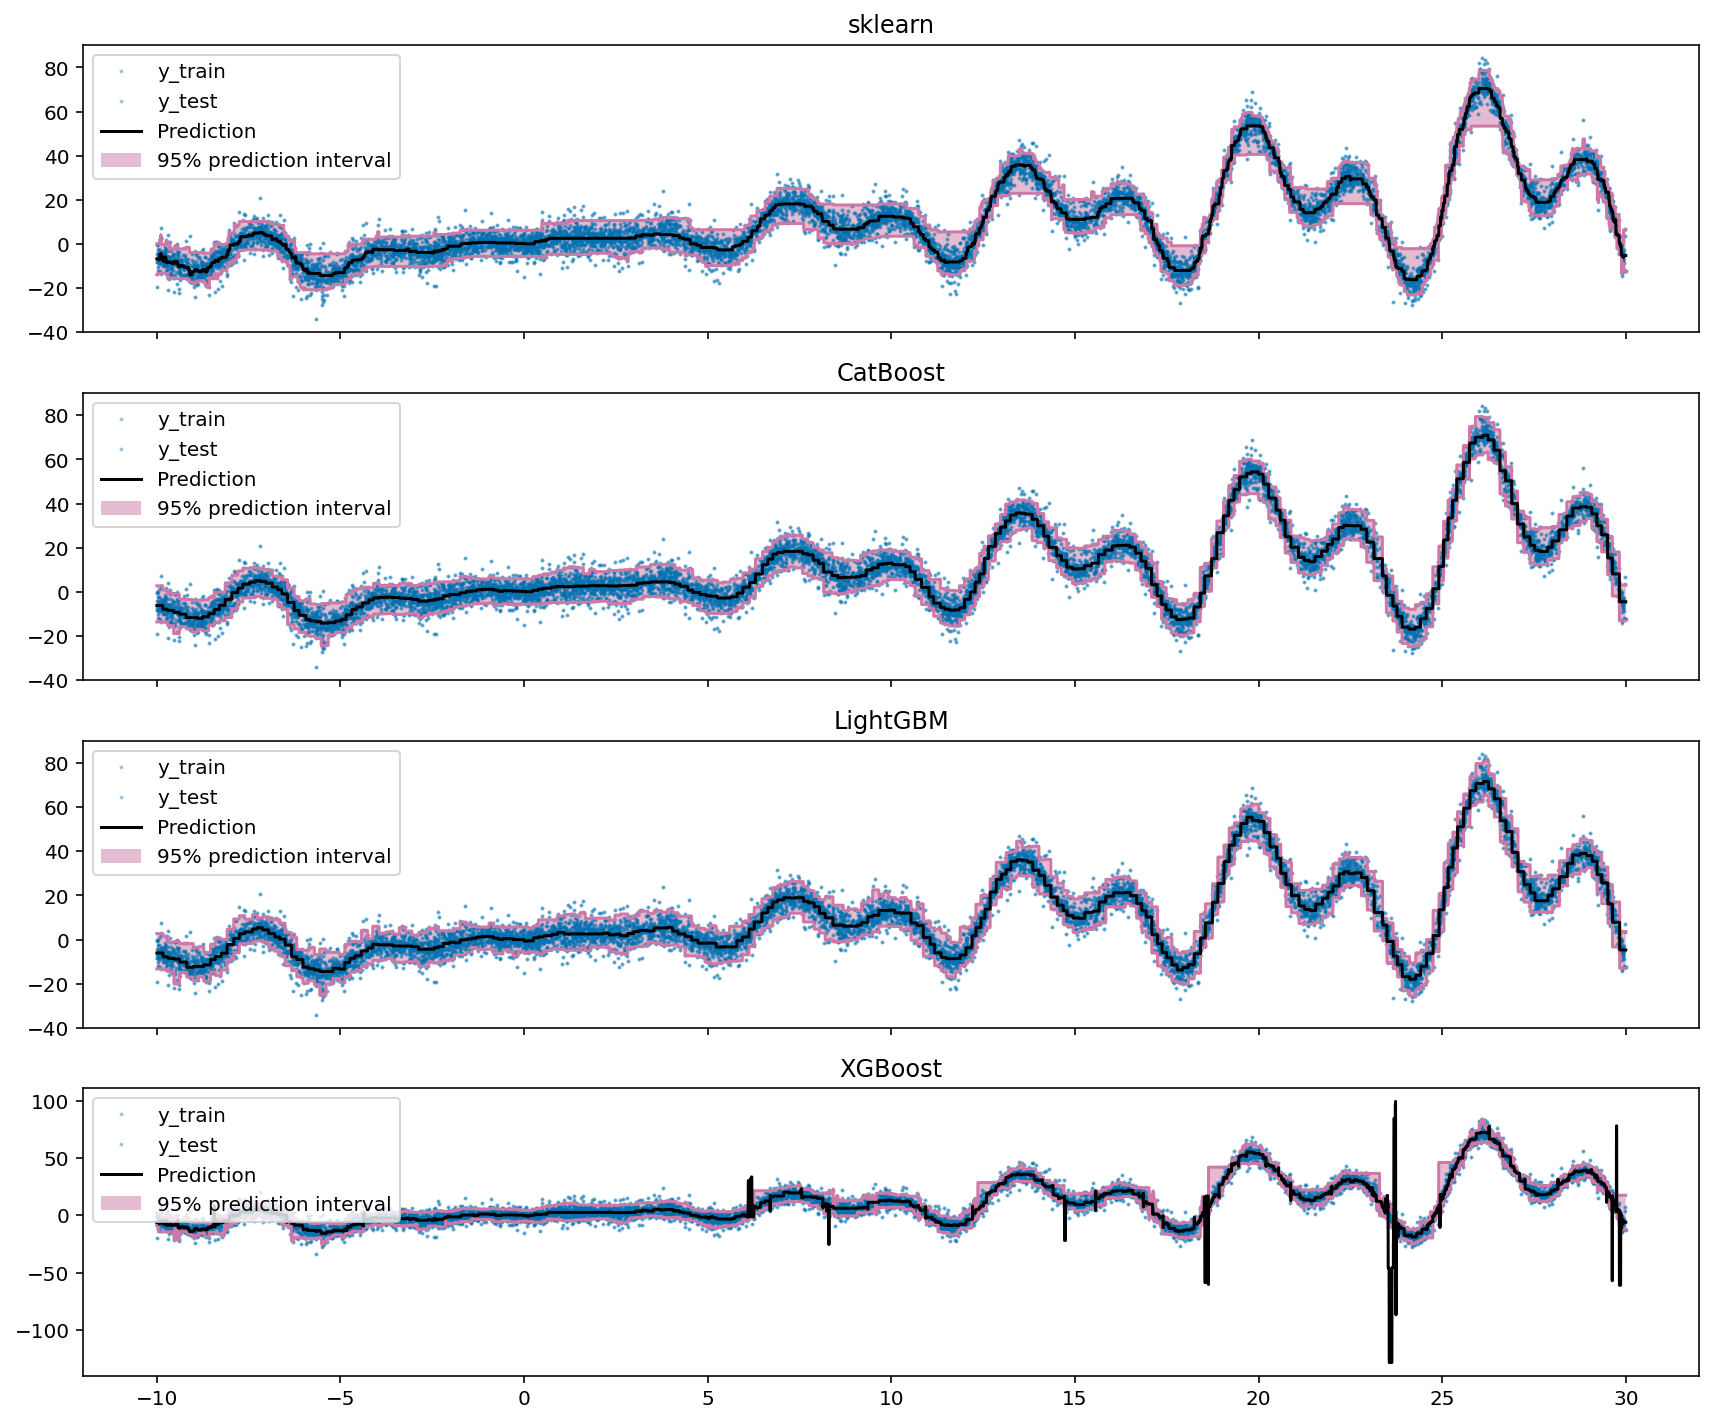

In [13]:
fig, ax = plt.subplots(len(preds), 1, figsize=(12, 2.5 * len(preds)), sharex=True)
for idx, (t, p) in enumerate(preds.items()):
    _ = plot_result_toax(ax=ax[idx], alpha=ALPHA, preds=p, data=data)
    ax[idx].set_title(t)
plt.tight_layout()

XGBoost WTF!